In [ ]:
!pip install -q efficientnet >> /dev/null

In [ ]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [ ]:
from google.colab import drive
# drive.mount('/content/gdrive')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
from keras.models import load_model
test_model = load_model("drive/My Drive/Colab Notebooks/seminar/EfficientNetB7.model")
"""

'\nfrom keras.models import load_model\ntest_model = load_model("drive/My Drive/Colab Notebooks/seminar/EfficientNetB7.model")\n'

In [ ]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256

# cataract dataset
# IMG_ROOT = '../input/cataractdataset/dataset/'
IMG_ROOT = 'drive/My Drive/Colab Notebooks/seminar/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal', 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma', 
           IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
OCU_IMG_ROOT = 'drive/My Drive/Colab Notebooks/seminar/ocular/ODIR-5K/Training Images/'
ocu_df = pd.read_excel('drive/My Drive/Colab Notebooks/seminar/ocular/ODIR-5K/data.xlsx')

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [ ]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3
        
# only sample normal and cataract        
cat_df = cat_df.query('0 <= cataract < 2')
cat_df

,paths,cataract
0,drive/My Drive/Colab Notebooks/seminar/dataset...,1
1,drive/My Drive/Colab Notebooks/seminar/dataset...,1
2,drive/My Drive/Colab Notebooks/seminar/dataset...,1
3,drive/My Drive/Colab Notebooks/seminar/dataset...,1
4,drive/My Drive/Colab Notebooks/seminar/dataset...,1
...,...,...
596,drive/My Drive/Colab Notebooks/seminar/dataset...,0
597,drive/My Drive/Colab Notebooks/seminar/dataset...,0
598,drive/My Drive/Colab Notebooks/seminar/dataset...,0
599,drive/My Drive/Colab Notebooks/seminar/dataset...,0


In [ ]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
0    300
1    100
Name: cataract, dtype: int64


In [ ]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [ ]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0
    
ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

In [ ]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [ ]:
le_df.head()
re_df.head()

,cataract,paths
0,0,drive/My Drive/Colab Notebooks/seminar/ocular/...
1,0,drive/My Drive/Colab Notebooks/seminar/ocular/...
2,0,drive/My Drive/Colab Notebooks/seminar/ocular/...
3,0,drive/My Drive/Colab Notebooks/seminar/ocular/...
4,0,drive/My Drive/Colab Notebooks/seminar/ocular/...


In [ ]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
0    3341
1     159
Name: cataract, dtype: int64

Number of right eye images
0    3346
1     154
Name: cataract, dtype: int64


In [ ]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']), 
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
1    159
0    159
Name: cataract, dtype: int64

Number of right eye images
1    154
0    154
Name: cataract, dtype: int64


In [ ]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,cataract,paths
0,1,drive/My Drive/Colab Notebooks/seminar/ocular/...
81,1,drive/My Drive/Colab Notebooks/seminar/ocular/...
103,1,drive/My Drive/Colab Notebooks/seminar/ocular/...
119,1,drive/My Drive/Colab Notebooks/seminar/ocular/...
253,1,drive/My Drive/Colab Notebooks/seminar/ocular/...


In [ ]:
df = pd.concat([cat_df, ocu_df], ignore_index=True)
df

,paths,cataract
0,drive/My Drive/Colab Notebooks/seminar/dataset...,1
1,drive/My Drive/Colab Notebooks/seminar/dataset...,1
2,drive/My Drive/Colab Notebooks/seminar/dataset...,1
3,drive/My Drive/Colab Notebooks/seminar/dataset...,1
4,drive/My Drive/Colab Notebooks/seminar/dataset...,1
...,...,...
1021,drive/My Drive/Colab Notebooks/seminar/ocular/...,0
1022,drive/My Drive/Colab Notebooks/seminar/ocular/...,0
1023,drive/My Drive/Colab Notebooks/seminar/ocular/...,0
1024,drive/My Drive/Colab Notebooks/seminar/ocular/...,0


In [ ]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [ ]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████| 206/206 [01:46<00:00,  1.94it/s]


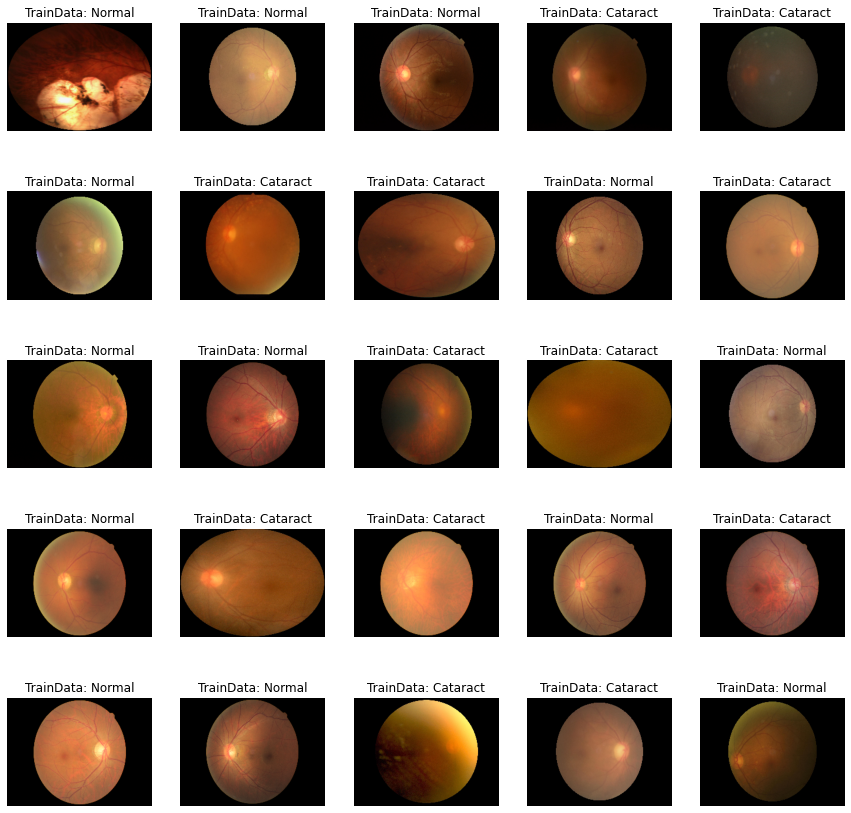

In [ ]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

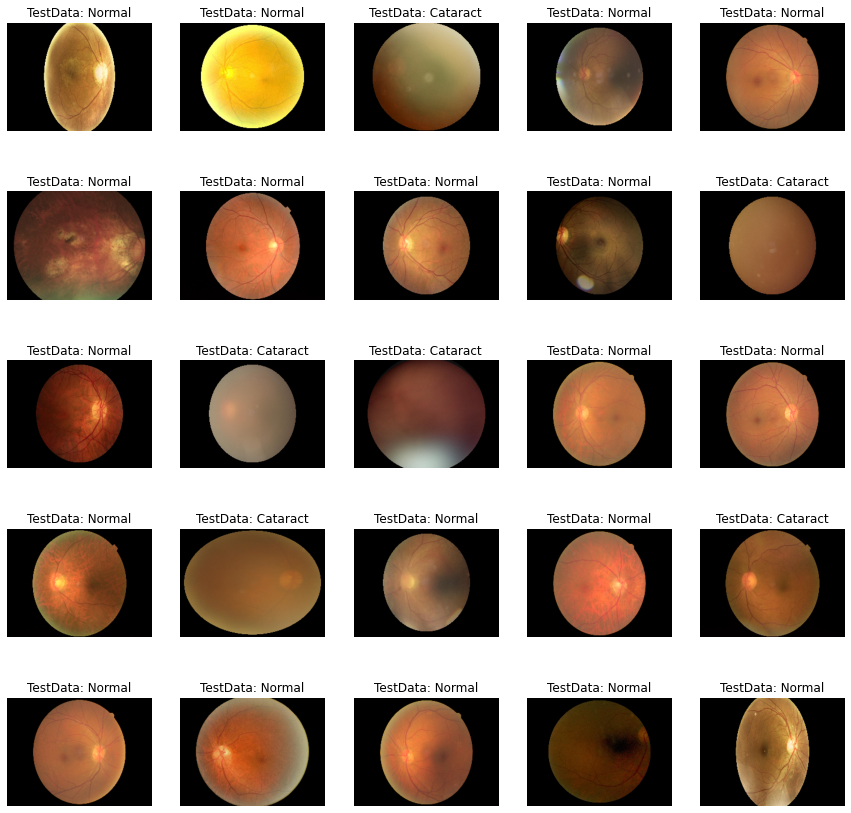

In [ ]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

In [ ]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import pickle
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras as keras
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import BatchNormalization

In [ ]:
base_model = InceptionV3(weights= "imagenet",include_top = False , input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))

for layer in base_model.layers:
    layer.trainable = True

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95, 127, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 127, 32)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
x=base_model.output
x=AveragePooling2D(pool_size=(3,3))(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dense(128,activation='relu')(x)
x=BatchNormalization()(x)
x=Flatten(name="flatten")(x)
x=Dense(32,activation='relu')(x)
# x=BatchNormalization()(x)
x=Dropout(0.25)(x)
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

In [ ]:
model=Model(inputs=base_model.input,outputs=preds)

adam = optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95, 127, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 127, 32)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
22/21 [==============================] - 12s 568ms/step - loss: 0.3294 - accuracy: 0.8795 - val_loss: 1.2932 - val_accuracy: 0.3984
Epoch 2/100
22/21 [==============================] - 13s 571ms/step - loss: 0.3241 - accuracy: 0.8881 - val_loss: 0.7429 - val_accuracy: 0.8374
Epoch 3/100
22/21 [==============================] - 12s 568ms/step - loss: 0.2535 - accuracy: 0.9154 - val_loss: 0.4392 - val_accuracy: 0.8618
Epoch 4/100
22/21 [==============================] - 13s 569ms/step - loss: 0.2303 - accuracy: 0.9067 - val_loss: 0.3330 - val_accuracy: 0.9268
Epoch 5/100
22/21 [==============================] - 12s 560ms/step - loss: 0.1835 - accuracy: 0.9182 - val_loss: 0.3960 - val_accuracy: 0.9106
Epoch 6/100
22/21 [==============================] - 12s 564ms/step - loss: 0.1851 - accuracy: 0.9297 - val_loss: 0.3698 - val_accuracy: 0.8943
Epoch 7/100
22/21 [==============================] - 12s 562ms/step - loss: 0.2072 - accuracy: 0.9297 - val_loss: 0.3918 - val_accuracy:

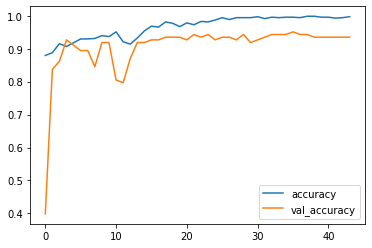

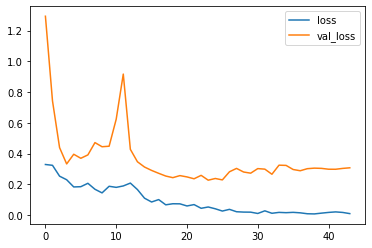

In [ ]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
model.save('drive/My Drive/Colab Notebooks/seminar/Transfer-InceptionV3.model')
model.save_weights('drive/My Drive/Colab Notebooks/seminar/Transfer-InceptionV3.h5')

INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/seminar/Transfer-InceptionV3.model/assets


In [ ]:
model.evaluate(test_imgs, test_df) 

7/7 [==============================] - 2s 256ms/step - loss: 0.2080 - accuracy: 0.9320


[0.20800887048244476, 0.9320388436317444]

In [ ]:
base_modeld = applications.densenet.DenseNet121(weights= None, include_top=False, input_shape= (IMG_HEIGHT, IMG_WIDTH, 3))

x = base_modeld.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation= 'sigmoid')(x)
modeld = Model(inputs = base_modeld.input, outputs = predictions)
modeld.compile(optimizer= 'RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
modeld.summary()

Model: "functional_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 198, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 96, 128, 64)  9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 96, 128, 64)  256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
historyd = modeld.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

Epoch 1/100
22/21 [==============================] - 23s 1s/step - loss: 0.7766 - accuracy: 0.6227 - val_loss: 1.1261 - val_accuracy: 0.4309
Epoch 2/100
22/21 [==============================] - 16s 726ms/step - loss: 0.6436 - accuracy: 0.6786 - val_loss: 0.7959 - val_accuracy: 0.4065
Epoch 3/100
22/21 [==============================] - 16s 716ms/step - loss: 0.6210 - accuracy: 0.7059 - val_loss: 1.5591 - val_accuracy: 0.4634
Epoch 4/100
22/21 [==============================] - 16s 714ms/step - loss: 0.6204 - accuracy: 0.6758 - val_loss: 8.8034 - val_accuracy: 0.3821
Epoch 5/100
22/21 [==============================] - 16s 716ms/step - loss: 0.6297 - accuracy: 0.6844 - val_loss: 77.5471 - val_accuracy: 0.3984
Epoch 6/100
22/21 [==============================] - 16s 715ms/step - loss: 0.6168 - accuracy: 0.6930 - val_loss: 236.3202 - val_accuracy: 0.3984
Epoch 7/100
22/21 [==============================] - 16s 714ms/step - loss: 0.6315 - accuracy: 0.6671 - val_loss: 24.5524 - val_accuracy

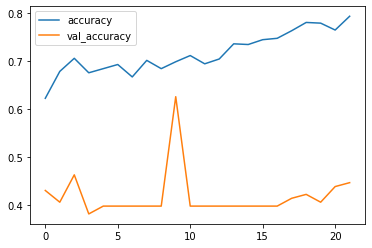

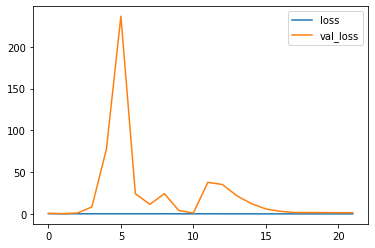

In [ ]:
pd.DataFrame(historyd.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(historyd.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
modeld.save('drive/My Drive/Colab Notebooks/seminar/dense121.model')
modeld.save_weights('drive/My Drive/Colab Notebooks/seminar/dense121.h5')

INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/seminar/dense121.model/assets


In [ ]:
modeld.evaluate(test_imgs, test_df) 

7/7 [==============================] - 2s 307ms/step - loss: 0.8195 - accuracy: 0.3883


[0.8194607496261597, 0.3883495032787323]

In [ ]:
from tensorflow.keras.applications import DenseNet121
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(2,activation='softmax')(x) #FC-layer

In [ ]:
modeld2=Model(inputs=model_d.input,outputs=preds)
modeld2.summary()

Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________

In [ ]:
modeld2.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
modeld2.summary()

Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________

In [ ]:
historyd2 = modeld2.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

Epoch 1/100
22/21 [==============================] - 17s 760ms/step - loss: 0.7408 - accuracy: 0.7819 - val_loss: 9.2272 - val_accuracy: 0.3984
Epoch 2/100
22/21 [==============================] - 14s 656ms/step - loss: 0.5327 - accuracy: 0.8522 - val_loss: 9.2272 - val_accuracy: 0.3984
Epoch 3/100
22/21 [==============================] - 14s 657ms/step - loss: 0.3768 - accuracy: 0.8766 - val_loss: 9.2272 - val_accuracy: 0.3984
Epoch 4/100
22/21 [==============================] - 15s 666ms/step - loss: 0.4057 - accuracy: 0.8465 - val_loss: 9.2086 - val_accuracy: 0.3984
Epoch 5/100
22/21 [==============================] - 15s 665ms/step - loss: 0.3410 - accuracy: 0.8766 - val_loss: 4.7780 - val_accuracy: 0.4553
Epoch 6/100
22/21 [==============================] - 14s 656ms/step - loss: 0.2630 - accuracy: 0.9082 - val_loss: 6.3571 - val_accuracy: 0.4715
Epoch 7/100
22/21 [==============================] - 15s 666ms/step - loss: 0.3104 - accuracy: 0.8752 - val_loss: 1.1342 - val_accuracy:

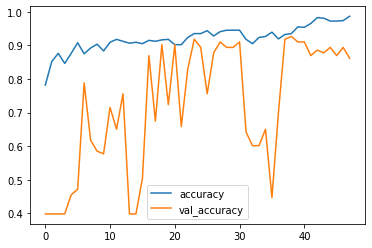

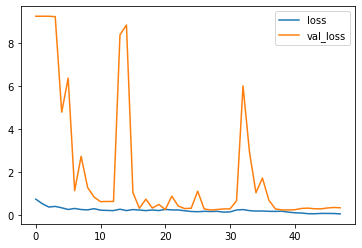

In [ ]:
pd.DataFrame(historyd2.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(historyd2.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
modeld2.save('drive/My Drive/Colab Notebooks/seminar/dense121(2).model')
modeld2.save_weights('drive/My Drive/Colab Notebooks/seminar/dense121(2).h5')

INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/seminar/dense121(2).model/assets


In [ ]:
modeld2.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 151ms/step - loss: 0.3188 - accuracy: 0.8883


[0.3187981843948364, 0.8883495330810547]

In [ ]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

modele = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
modele.summary()

16809984/16804768 [==============================] - 2s 0us/step
Model: "functional_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 6, 8, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
historye = modele.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

Epoch 1/100
22/21 [==============================] - 15s 676ms/step - loss: 0.6857 - accuracy: 0.5624 - val_loss: 0.6549 - val_accuracy: 0.5935
Epoch 2/100
22/21 [==============================] - 12s 544ms/step - loss: 0.6434 - accuracy: 0.6385 - val_loss: 0.6588 - val_accuracy: 0.5935
Epoch 3/100
22/21 [==============================] - 12s 536ms/step - loss: 0.6153 - accuracy: 0.6714 - val_loss: 0.6461 - val_accuracy: 0.6341
Epoch 4/100
22/21 [==============================] - 12s 544ms/step - loss: 0.5801 - accuracy: 0.7590 - val_loss: 0.6315 - val_accuracy: 0.6748
Epoch 5/100
22/21 [==============================] - 12s 539ms/step - loss: 0.5447 - accuracy: 0.7762 - val_loss: 0.6171 - val_accuracy: 0.6911
Epoch 6/100
22/21 [==============================] - 12s 543ms/step - loss: 0.5232 - accuracy: 0.7977 - val_loss: 0.6040 - val_accuracy: 0.6911
Epoch 7/100
22/21 [==============================] - 12s 540ms/step - loss: 0.5008 - accuracy: 0.8063 - val_loss: 0.5964 - val_accuracy:

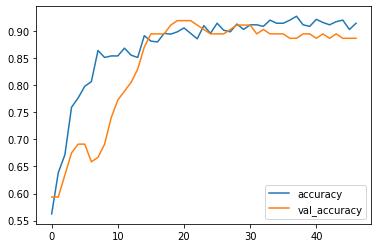

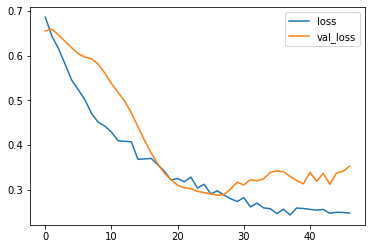

In [ ]:
pd.DataFrame(historye.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(historye.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
modele.save('drive/My Drive/Colab Notebooks/seminar/EfficientNetB0.model')
modele.save_weights('drive/My Drive/Colab Notebooks/seminar/EfficientNetB0.h5')

INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/seminar/EfficientNetB0.model/assets


In [ ]:
modele.evaluate(test_imgs, test_df) 

7/7 [==============================] - 1s 159ms/step - loss: 0.2780 - accuracy: 0.9029


[0.27801012992858887, 0.9029126167297363]

In [ ]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

models = Sequential()
models.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
models.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
models.add(BatchNormalization())
models.add(MaxPool2D(3))
models.add(Dropout(0.3))
models.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
models.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
models.add(BatchNormalization())
models.add(MaxPool2D(3))
models.add(Dropout(0.3))
models.add(Flatten())
models.add(Dense(2, activation='softmax'))
models.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


models.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 192, 256, 16)      448       
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 192, 256, 16)      2320      
_________________________________________________________________
batch_normalization_104 (Bat (None, 192, 256, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 85, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 85, 16)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 64, 85, 16)        2320      
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 64, 85, 16)       

In [ ]:
historys = models.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

Epoch 1/100
22/21 [==============================] - 8s 382ms/step - loss: 1.4481 - accuracy: 0.6356 - val_loss: 0.6882 - val_accuracy: 0.4634
Epoch 2/100
22/21 [==============================] - 8s 367ms/step - loss: 1.2237 - accuracy: 0.6600 - val_loss: 0.7134 - val_accuracy: 0.3984
Epoch 3/100
22/21 [==============================] - 8s 359ms/step - loss: 1.0671 - accuracy: 0.7001 - val_loss: 0.7056 - val_accuracy: 0.3984
Epoch 4/100
22/21 [==============================] - 8s 364ms/step - loss: 0.8636 - accuracy: 0.7202 - val_loss: 0.7776 - val_accuracy: 0.3984
Epoch 5/100
22/21 [==============================] - 8s 365ms/step - loss: 0.8381 - accuracy: 0.7217 - val_loss: 0.7062 - val_accuracy: 0.3984
Epoch 6/100
22/21 [==============================] - 8s 365ms/step - loss: 0.6391 - accuracy: 0.7719 - val_loss: 0.7555 - val_accuracy: 0.3984
Epoch 7/100
22/21 [==============================] - 8s 367ms/step - loss: 0.6722 - accuracy: 0.7504 - val_loss: 0.7005 - val_accuracy: 0.4309

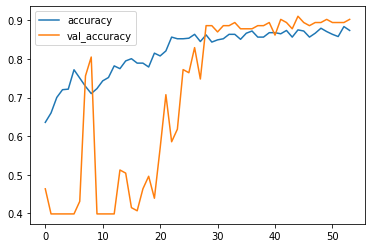

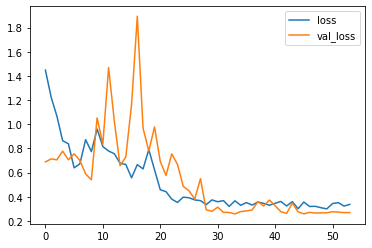

In [ ]:
pd.DataFrame(historys.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(historys.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
models.save('drive/My Drive/Colab Notebooks/seminar/sequential.model')
models.save_weights('drive/My Drive/Colab Notebooks/seminar/sequential.h5')

INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/seminar/sequential.model/assets


In [ ]:
models.evaluate(test_imgs, test_df) 

7/7 [==============================] - 0s 69ms/step - loss: 0.3491 - accuracy: 0.8689


[0.3490752577781677, 0.8689320683479309]

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

models2 = Sequential()
models2.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
models2.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
models2.add(BatchNormalization())
models2.add(MaxPool2D(3))
models2.add(Dropout(0.3))
models2.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
models2.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
models2.add(BatchNormalization())
models2.add(MaxPool2D(3))
models2.add(Dropout(0.3))
models2.add(Flatten())
models2.add(Dense(2, activation='softmax'))
models2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


models2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 192, 256, 16)      448       
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 192, 256, 16)      2320      
_________________________________________________________________
batch_normalization_106 (Bat (None, 192, 256, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 85, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 85, 16)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 64, 85, 16)        2320      
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 64, 85, 16)       

In [ ]:
historys2 = models2.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

Epoch 1/100
22/21 [==============================] - 8s 375ms/step - loss: 1.8102 - accuracy: 0.6298 - val_loss: 0.6416 - val_accuracy: 0.6585
Epoch 2/100
22/21 [==============================] - 8s 361ms/step - loss: 1.0109 - accuracy: 0.6815 - val_loss: 0.6239 - val_accuracy: 0.6504
Epoch 3/100
22/21 [==============================] - 8s 362ms/step - loss: 1.0019 - accuracy: 0.7145 - val_loss: 0.6246 - val_accuracy: 0.6341
Epoch 4/100
22/21 [==============================] - 8s 363ms/step - loss: 1.0923 - accuracy: 0.7188 - val_loss: 0.6249 - val_accuracy: 0.6423
Epoch 5/100
22/21 [==============================] - 8s 363ms/step - loss: 0.8454 - accuracy: 0.7346 - val_loss: 0.7758 - val_accuracy: 0.6179
Epoch 6/100
22/21 [==============================] - 8s 363ms/step - loss: 0.8623 - accuracy: 0.7288 - val_loss: 0.7851 - val_accuracy: 0.4065
Epoch 7/100
22/21 [==============================] - 8s 364ms/step - loss: 0.6785 - accuracy: 0.7719 - val_loss: 0.6182 - val_accuracy: 0.6423

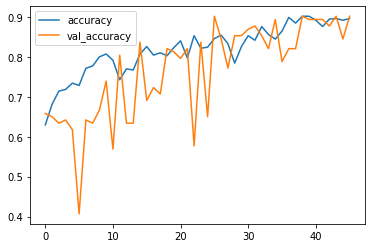

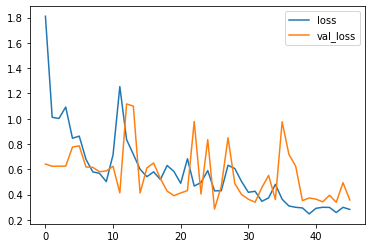

In [ ]:
pd.DataFrame(historys2.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(historys2.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
models2.save('drive/My Drive/Colab Notebooks/seminar/sequential(2).model')
models2.save_weights('drive/My Drive/Colab Notebooks/seminar/sequential(2).h5')

INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/seminar/sequential(2).model/assets


In [ ]:
models2.evaluate(test_imgs, test_df)

7/7 [==============================] - 0s 44ms/step - loss: 0.4529 - accuracy: 0.8398


[0.45289433002471924, 0.8398058414459229]

In [ ]:
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
import os

In [ ]:
nasnet = tf.keras.applications.NASNetMobile(input_shape=None, include_top=True, weights='imagenet', input_tensor=None,pooling=None, classes=1000)

24231936/24227760 [==============================] - 1s 0us/step


In [ ]:
for layer in nasnet.layers:
    layer.trainable = True

In [ ]:
nasnet.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_17[0][0]                   
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_615 (Activation)     (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [ ]:
x=nasnet.output
# x=AveragePooling2D(pool_size=(3,3))(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dense(128,activation='relu')(x)
x=BatchNormalization()(x)
x=Flatten(name="flatten")(x)
x=Dense(32,activation='relu')(x)
# x=BatchNormalization()(x)
x=Dropout(0.25)(x)
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation
modeln=Model(inputs=nasnet.input,outputs=preds)

adam = optimizers.Adam(learning_rate=0.001)

modeln.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
modeln.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_17[0][0]                   
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_615 (Activation)     (None, 111, 111, 32) 0           stem_bn1[0][0]                   
______________________________________________________________________________________

In [ ]:
historyn = modeln.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

Epoch 1/100
22/21 [==============================] - 21s 943ms/step - loss: 0.5536 - accuracy: 0.7590 - val_loss: 0.6784 - val_accuracy: 0.6016
Epoch 2/100
22/21 [==============================] - 16s 710ms/step - loss: 0.4269 - accuracy: 0.8278 - val_loss: 0.6732 - val_accuracy: 0.6016
Epoch 3/100
22/21 [==============================] - 16s 711ms/step - loss: 0.3543 - accuracy: 0.8479 - val_loss: 0.6662 - val_accuracy: 0.7805
Epoch 4/100
22/21 [==============================] - 16s 707ms/step - loss: 0.3688 - accuracy: 0.8637 - val_loss: 0.6622 - val_accuracy: 0.8862
Epoch 5/100
22/21 [==============================] - 15s 694ms/step - loss: 0.3654 - accuracy: 0.8651 - val_loss: 0.6642 - val_accuracy: 0.6748
Epoch 6/100
22/21 [==============================] - 15s 692ms/step - loss: 0.3529 - accuracy: 0.8680 - val_loss: 0.7040 - val_accuracy: 0.4715
Epoch 7/100
22/21 [==============================] - 15s 696ms/step - loss: 0.3111 - accuracy: 0.8723 - val_loss: 0.6935 - val_accuracy:

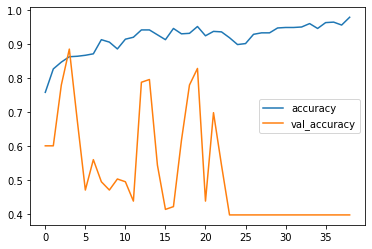

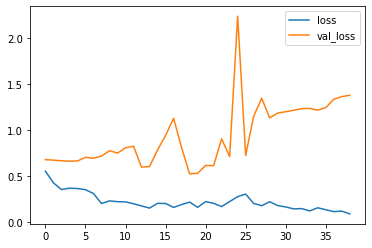

In [ ]:
pd.DataFrame(historyn.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(historyn.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
modeln.save('drive/My Drive/Colab Notebooks/seminar/nasnet_mobile.model')
modeln.save_weights('drive/My Drive/Colab Notebooks/seminar/nasnet_mobile.h5')

INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/seminar/nasnet_mobile.model/assets


In [ ]:
modeln.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 149ms/step - loss: 0.5469 - accuracy: 0.7621


[0.5468906760215759, 0.762135922908783]

In [ ]:
nasnetl = tf.keras.applications.NASNetLarge(input_shape=None, include_top=True, weights='imagenet', input_tensor=None,pooling=None, classes=1000)
for layer in nasnetl.layers:
    layer.trainable = True

nasnetl.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_19[0][0]                   
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1063 (Activation)    (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [ ]:
x=nasnetl.output
# x=AveragePooling2D(pool_size=(3,3))(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dense(128,activation='relu')(x)
x=BatchNormalization()(x)
x=Flatten(name="flatten")(x)
x=Dense(32,activation='relu')(x)
# x=BatchNormalization()(x)
x=Dropout(0.25)(x)
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation
modelnl=Model(inputs=nasnetl.input,outputs=preds)

adam = optimizers.Adam(learning_rate=0.001)

modelnl.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])


In [ ]:
modelnl.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_19[0][0]                   
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1063 (Activation)    (None, 165, 165, 96) 0           stem_bn1[0][0]                   
______________________________________________________________________________________

In [ ]:
historynl = modelnl.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=16), 
                    epochs=10,
                    steps_per_epoch=len(train_imgs)/16,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

Epoch 1/10
44/43 [==============================] - 86s 2s/step - loss: 0.6904 - accuracy: 0.5954 - val_loss: 0.7159 - val_accuracy: 0.6016
Epoch 2/10
44/43 [==============================] - 85s 2s/step - loss: 0.6932 - accuracy: 0.5983 - val_loss: 0.6828 - val_accuracy: 0.6016
Epoch 3/10
44/43 [==============================] - 85s 2s/step - loss: 0.6800 - accuracy: 0.6083 - val_loss: 0.6742 - val_accuracy: 0.6016
Epoch 4/10
44/43 [==============================] - 83s 2s/step - loss: 0.6577 - accuracy: 0.6313 - val_loss: 0.6751 - val_accuracy: 0.6016
Epoch 5/10
44/43 [==============================] - 83s 2s/step - loss: 0.6603 - accuracy: 0.6255 - val_loss: 0.6756 - val_accuracy: 0.6016
Epoch 6/10
44/43 [==============================] - 82s 2s/step - loss: 0.6546 - accuracy: 0.6327 - val_loss: 0.6946 - val_accuracy: 0.3984
Epoch 7/10
44/43 [==============================] - 83s 2s/step - loss: 0.6271 - accuracy: 0.6600 - val_loss: 0.8926 - val_accuracy: 0.3984
Epoch 8/10
44/43 [==

In [ ]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB5(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

modele5 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
modele5.summary()

115515392/115515256 [==============================] - 8s 0us/step
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b5 (Functional) (None, 6, 8, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 4098      
Total params: 28,517,618
Trainable params: 28,344,882
Non-trainable params: 172,736
_________________________________________________________________


In [ ]:
historye5 = modele5.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=16), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/16,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

Epoch 1/100
44/43 [==============================] - 46s 1s/step - loss: 0.5938 - accuracy: 0.7145 - val_loss: 0.6339 - val_accuracy: 0.6992
Epoch 2/100
44/43 [==============================] - 45s 1s/step - loss: 0.5687 - accuracy: 0.7604 - val_loss: 0.6266 - val_accuracy: 0.6829
Epoch 3/100
44/43 [==============================] - 45s 1s/step - loss: 0.5315 - accuracy: 0.8020 - val_loss: 0.5943 - val_accuracy: 0.7317
Epoch 4/100
44/43 [==============================] - 45s 1s/step - loss: 0.5064 - accuracy: 0.8264 - val_loss: 0.5473 - val_accuracy: 0.8537
Epoch 5/100
44/43 [==============================] - 45s 1s/step - loss: 0.4788 - accuracy: 0.8350 - val_loss: 0.5071 - val_accuracy: 0.8537
Epoch 6/100
44/43 [==============================] - 45s 1s/step - loss: 0.4684 - accuracy: 0.8393 - val_loss: 0.4735 - val_accuracy: 0.8780
Epoch 7/100
44/43 [==============================] - 46s 1s/step - loss: 0.4488 - accuracy: 0.8465 - val_loss: 0.4417 - val_accuracy: 0.8862
Epoch 8/100
4

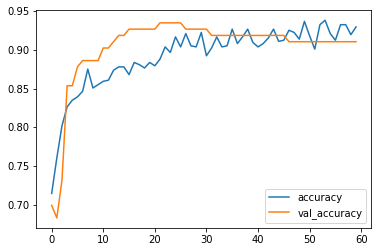

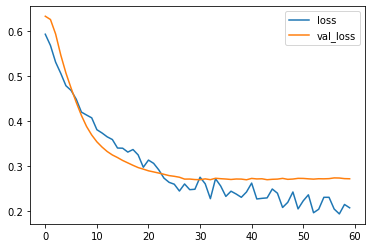

In [ ]:
pd.DataFrame(historye5.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(historye5.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
modele5.save('drive/My Drive/Colab Notebooks/seminar/EfficientNetB5.model')
modele5.save_weights('drive/My Drive/Colab Notebooks/seminar/EfficientNetB5.h5')

INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/seminar/EfficientNetB5.model/assets


In [ ]:
modele5.evaluate(test_imgs, test_df) 

7/7 [==============================] - 3s 424ms/step - loss: 0.2379 - accuracy: 0.9078


[0.23790542781352997, 0.9077669978141785]

In [ ]:
def build_modele7(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB7(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

modele7 = build_modele7(IMG_HEIGHT, IMG_WIDTH, 3)
modele7.summary()

258441216/258434480 [==============================] - 17s 0us/step
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b7 (Functional) (None, 6, 8, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d_12  (None, 2560)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 5122      
Total params: 64,102,802
Trainable params: 63,792,082
Non-trainable params: 310,720
_________________________________________________________________


In [ ]:
historye7 = modele7.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=8), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/8,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

Epoch 1/100
88/87 [==============================] - 88s 1s/step - loss: 0.6215 - accuracy: 0.7044 - val_loss: 0.5887 - val_accuracy: 0.7561
Epoch 2/100
88/87 [==============================] - 88s 1s/step - loss: 0.5740 - accuracy: 0.7690 - val_loss: 0.5358 - val_accuracy: 0.8130
Epoch 3/100
88/87 [==============================] - 88s 1s/step - loss: 0.5377 - accuracy: 0.7891 - val_loss: 0.4728 - val_accuracy: 0.8699
Epoch 4/100
88/87 [==============================] - 88s 1s/step - loss: 0.5022 - accuracy: 0.8164 - val_loss: 0.4211 - val_accuracy: 0.8780
Epoch 5/100
88/87 [==============================] - 88s 1s/step - loss: 0.4763 - accuracy: 0.8278 - val_loss: 0.3908 - val_accuracy: 0.8780
Epoch 6/100
88/87 [==============================] - 88s 1s/step - loss: 0.4536 - accuracy: 0.8235 - val_loss: 0.3705 - val_accuracy: 0.8943
Epoch 7/100
88/87 [==============================] - 88s 1s/step - loss: 0.4235 - accuracy: 0.8422 - val_loss: 0.3511 - val_accuracy: 0.8943
Epoch 8/100
8

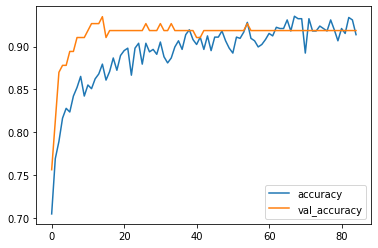

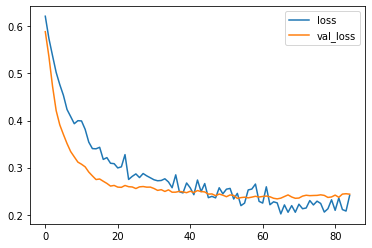

In [ ]:
pd.DataFrame(historye7.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(historye7.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
modele7.save('drive/My Drive/Colab Notebooks/seminar/EfficientNetB7.model')
modele7.save_weights('drive/My Drive/Colab Notebooks/seminar/EfficientNetB7.h5')

INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/seminar/EfficientNetB7.model/assets


In [ ]:
modele7.evaluate(test_imgs, test_df)

7/7 [==============================] - 5s 699ms/step - loss: 0.1924 - accuracy: 0.9223


[0.1924329400062561, 0.9223300814628601]

In [ ]:
resnet = tf.keras.applications.ResNet50(input_shape=None, include_top=True, weights='imagenet', input_tensor=None,pooling=None, classes=1000)

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet.layers:
    layer.trainable = True

In [ ]:
x=resnet.output
# x=AveragePooling2D(pool_size=(3,3))(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dense(128,activation='relu')(x)
x=BatchNormalization()(x)
x=Flatten(name="flatten")(x)
x=Dense(32,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.25)(x)
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation
modelr=Model(inputs=resnet.input,outputs=preds)

adam = optimizers.Adam(learning_rate=0.001)

modelr.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
modelr.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
historyres = modelr.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=8), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/8,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

Epoch 1/100
88/87 [==============================] - 12s 135ms/step - loss: 0.8069 - accuracy: 0.5466 - val_loss: 0.7020 - val_accuracy: 0.3984
Epoch 2/100
88/87 [==============================] - 10s 113ms/step - loss: 0.7246 - accuracy: 0.6126 - val_loss: 0.7318 - val_accuracy: 0.3984
Epoch 3/100
88/87 [==============================] - 10s 114ms/step - loss: 0.6966 - accuracy: 0.6198 - val_loss: 0.7804 - val_accuracy: 0.3984
Epoch 4/100
88/87 [==============================] - 10s 113ms/step - loss: 0.7489 - accuracy: 0.6055 - val_loss: 0.7074 - val_accuracy: 0.3984
Epoch 5/100
88/87 [==============================] - 10s 116ms/step - loss: 0.7241 - accuracy: 0.5696 - val_loss: 0.6927 - val_accuracy: 0.6016
Epoch 6/100
88/87 [==============================] - 10s 116ms/step - loss: 0.7087 - accuracy: 0.6198 - val_loss: 0.6724 - val_accuracy: 0.6016
Epoch 7/100
88/87 [==============================] - 10s 115ms/step - loss: 0.6913 - accuracy: 0.6284 - val_loss: 0.9151 - val_accuracy:

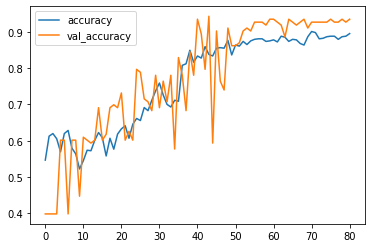

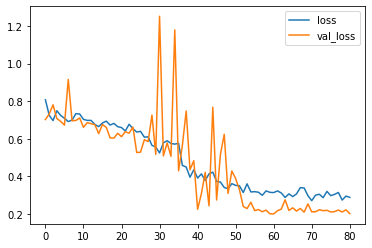

In [ ]:
pd.DataFrame(historyres.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(historyres.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
modelr.save('drive/My Drive/Colab Notebooks/seminar/ResNet50.model')
modelr.save_weights('drive/My Drive/Colab Notebooks/seminar/ResNet50.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/seminar/ResNet50.model/assets


In [ ]:
modelr.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 110ms/step - loss: 0.2719 - accuracy: 0.9078


[0.271945983171463, 0.9077669978141785]

In [ ]:
resnet152 = tf.keras.applications.ResNet152(input_shape=None, include_top=True, weights='imagenet', input_tensor=None,pooling=None, classes=1000)

242900992/242900224 [==============================] - 5s 0us/step


In [ ]:
for layer in resnet152.layers:
    layer.trainable = True

In [ ]:
x=resnet152.output
# x=AveragePooling2D(pool_size=(3,3))(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dense(128,activation='relu')(x)
x=BatchNormalization()(x)
x=Flatten(name="flatten")(x)
x=Dense(32,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.25)(x)
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation
modelr152=Model(inputs=resnet152.input,outputs=preds)

adam = optimizers.Adam(learning_rate=0.001)

modelr152.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
modelr152.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
historyres152 = modelr152.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

Epoch 1/100
22/21 [==============================] - 19s 870ms/step - loss: 0.7624 - accuracy: 0.6743 - val_loss: 0.6767 - val_accuracy: 0.6016
Epoch 2/100
22/21 [==============================] - 18s 796ms/step - loss: 0.7560 - accuracy: 0.6370 - val_loss: 0.6727 - val_accuracy: 0.6016
Epoch 3/100
22/21 [==============================] - 17s 794ms/step - loss: 0.7331 - accuracy: 0.6241 - val_loss: 0.6723 - val_accuracy: 0.6016
Epoch 4/100
22/21 [==============================] - 17s 752ms/step - loss: 0.8080 - accuracy: 0.6040 - val_loss: 0.6729 - val_accuracy: 0.6016
Epoch 5/100
22/21 [==============================] - 16s 745ms/step - loss: 0.7444 - accuracy: 0.6341 - val_loss: 0.6724 - val_accuracy: 0.6016
Epoch 6/100
22/21 [==============================] - 17s 751ms/step - loss: 0.7107 - accuracy: 0.6098 - val_loss: 0.6725 - val_accuracy: 0.6016
Epoch 7/100
22/21 [==============================] - 17s 754ms/step - loss: 0.6980 - accuracy: 0.6858 - val_loss: 0.6728 - val_accuracy:

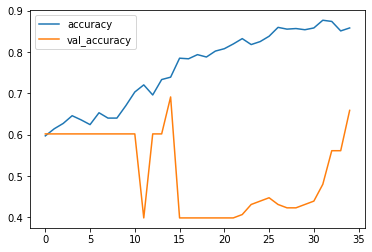

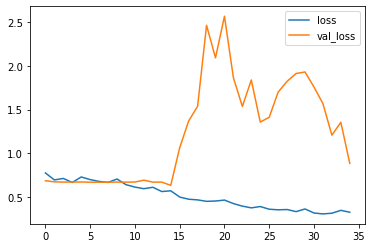

In [ ]:
pd.DataFrame(historyres101.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(historyres101.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
modelr101.save('drive/My Drive/Colab Notebooks/seminar/ResNet101.model')
modelr101.save_weights('drive/My Drive/Colab Notebooks/seminar/ResNet101.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/seminar/ResNet50.model/assets


In [ ]:
modelr101.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 112ms/step - loss: 0.6482 - accuracy: 0.6748


[0.6482125520706177, 0.6747573018074036]